# Deffaunt-Weisbuch Model with Heterogeneous Activation Probability
## Author: Grace Li
## Created On: 10/20/2021

This python code combines the generated matfiles from parallel computations.
The combined matfile is then used to generate various plots and heatmaps as confindence radius d (labeled c) and compromise parameter mu (labeled m) vary.

In [1]:
# import required packages  

import numpy as np
import pandas as pd
from scipy import io, stats
import os
import random
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
import time as time
import igraph as igraph


# #this line is to make sure the animation writer can find the ffmpeg executable if we want to generate an animation
# plt.rcParams['animation.ffmpeg_path'] = r'/home/graceli/.local/lib/ffmpeg-4.3.2-amd64-static/ffmpeg'


In [2]:
# Import our own DW module
import sys
sys.path.append('..') #look one directory above
import DW as DW

In [3]:
# Define graph type and weight distribution
graph_type = "complete"
# distribution = "Pareto-90-10"
distributions = ["Constant", "Uniform-80-10", "Exp-80-10", "Pareto-80-10"]

#Specify which quantities to generate plots of
keys = [
        'log(T)', 'log(T_changed)', 
        'entropy',
        'n_minor', 'n_clusters_major',
        'avg_local_receptiveness',
        'op_var'
       ]
# keys = ['entropy']

#Specify folder name for saving plots
directory = 'GraphSizePlots/combined'
#Check that a directory exists, and if not, create it
if not os.path.exists(directory):
    os.makedirs(directory)

In [4]:
#specify graph sizes (number of nodes)
Ns = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
Ns = [10, 20, 30, 45, 65, 100, 150, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

#specify confidence radii ds and compromise parameters mus

'''
NOTE: THE CONFIDENCE RADIUS IS CALLED d HERE, BUT c IN THE PAPER
NOTE: THE COMPROMISE PARAMETER IS CALLED mu HERE, BUT m IN THE PAPER
'''

ds = [0.1, 0.3, 0.5]
mus = [0.3, 0.5]

In [5]:
#Plot parameters
# sns.set_theme(style="whitegrid")

#Plot font size parameters
fontsizes = {'XS': 10, 'S': 18, 'M': 28, 'L':35, 'XL': 40} 

plot_height = 5.5
plot_width = 6.5

rows, cols = len(mus), len(ds)
figsize = (plot_width*cols, plot_height*rows)

bbox_to_anchor=(1.0, 0.5)

#Names for plots and save files
plot_name = {
                'log(T)': 'T', 'log(T_changed)': 'T_changed',
                'n_clusters': 'clusters', 'entropy' : 'entropy',
                'n_minor' : 'minor_clusters',
                'n_clusters_major' : 'major_clusters',
                'entropy_major' : 'entropy_major',
                'avg_opinion_diff': 'op_diff', 
                'avg_local_agreement' : 'agreement', 
                'avg_local_receptiveness': 'receptiveness',
                'op_mean': 'op_mean', 'op_var': 'op_var', 
                'op_skew': 'op_skew', 'op_kurtosis': 'op_kurtosis'
            }
plot_title = {
                'log(T)': r"$\log_{10}(T)$", 
                'log(T_changed)': r"$\log_{10}(T_{\mathrm{changed}})$",
                'n_clusters': 'Number of Clusters', 
                'entropy': r"Shannon Entropy $(H)$",
                'n_minor' : 'Number of Minor Clusters',
                'n_clusters_major' : 'Number of Major Clusters',
                'entropy_major' : 'Shannon Entropy of Major Clusters',
                'avg_opinion_diff': 'Mean Opinion Difference',
                'avg_local_agreement': 'Mean Local Agreement', 
                'avg_local_receptiveness': r"Mean Local Receptiveness $\langle LR_i(T) \rangle$", 
                'op_mean': 'Opinion Mean', 'op_var': 'Opinion Variance', 
                'op_skew': 'Opinion Skew', 'op_kurtosis': 'Opinion Kurtosis'
             }

In [6]:
#For each graph size, load the graph-level simulation results stored csv files and combine them

# columns = ['N', 'distribution', 'd', 'mu', 'weight_set', 'opinion_set',
#            'n_clusters', 'n_minor', 'n_clusters_major', 
#            'bailout', 'entropy', 'entropy_major', 
#            'avg_local_agreement', 'avg_local_receptiveness',
#            'T', 'T_changed', 'avg_opinion_diff',
#            'op_mean', 'op_var', 'op_skew', 'op_kurtosis']

#Here's a quick function to do so
def get_sim_results(n, distribution):
    #Read the stored simulation results for this graph size
    filename = graph_type + str(n) + "/" + distribution + '/combined_matfiles/simulation_results.csv'
    sim_results = pd.read_csv(filename)

    #Include the graph size and distribution in the data frame
    sim_results['N'] = [int(n)] * len(sim_results)
    sim_results['distribution'] = [distribution] * len(sim_results)
    
    #Make sure the graph, weight_set and opinion_set, and time steps are integers instead of floats
    sim_results = sim_results.astype({'weight_set': int, 'opinion_set': int,
                                     'T': int, 'T_changed': int, 'N': int})

    #Calculate the natural log of time steps to make it easier to visualize
    sim_results['log(T)'] = np.log10(sim_results['T'])
    sim_results['log(T_changed)'] = np.log10(sim_results['T_changed'])
    
    return sim_results

In [7]:
pal = sns.color_palette("colorblind")
print(pal.as_hex())

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


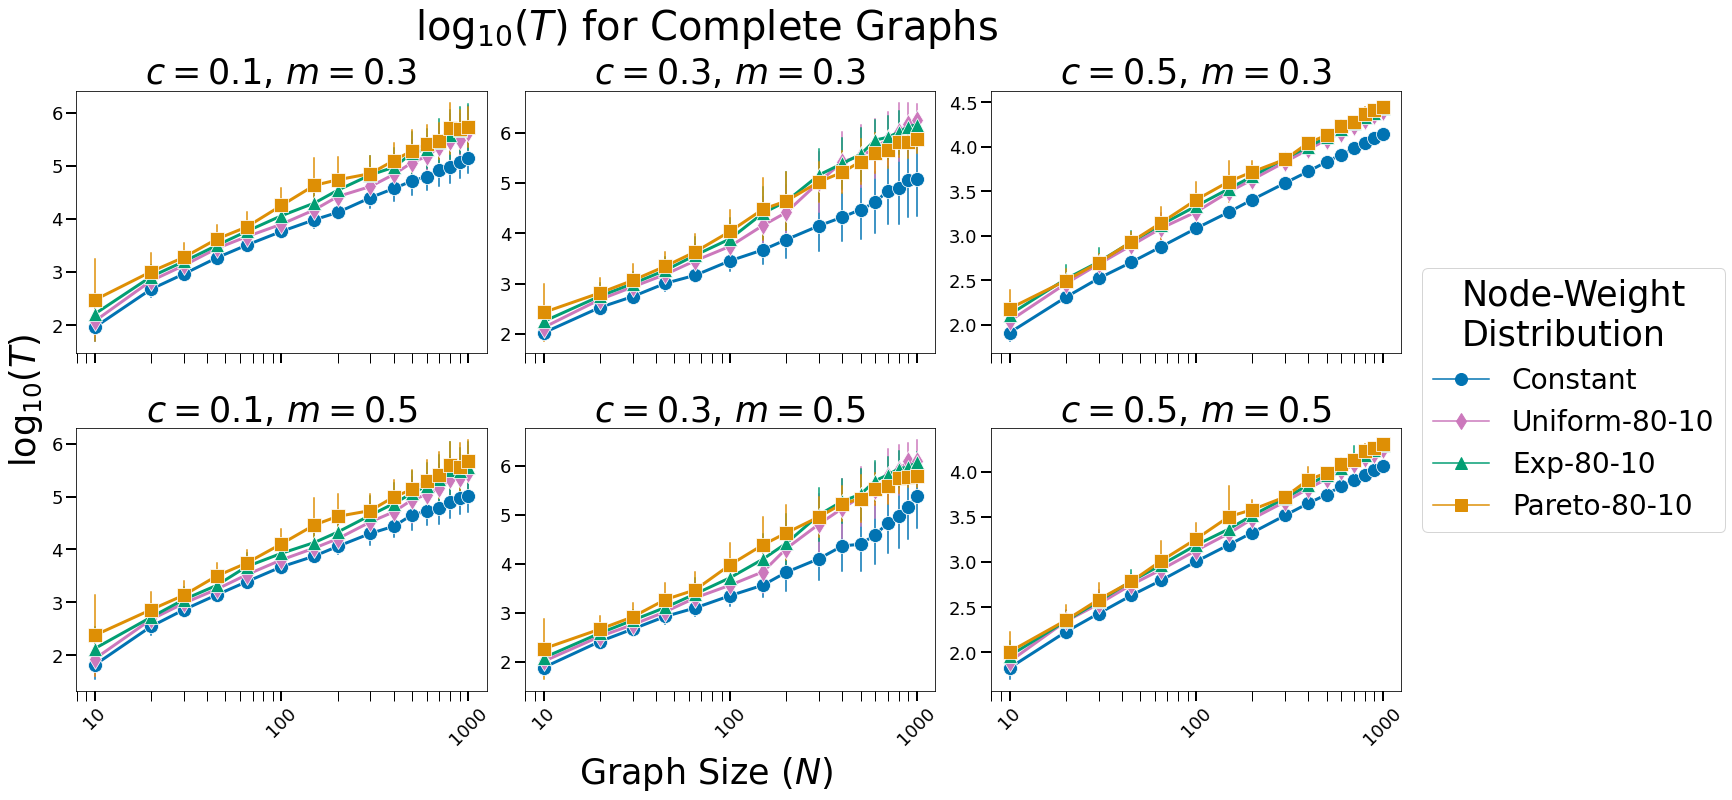

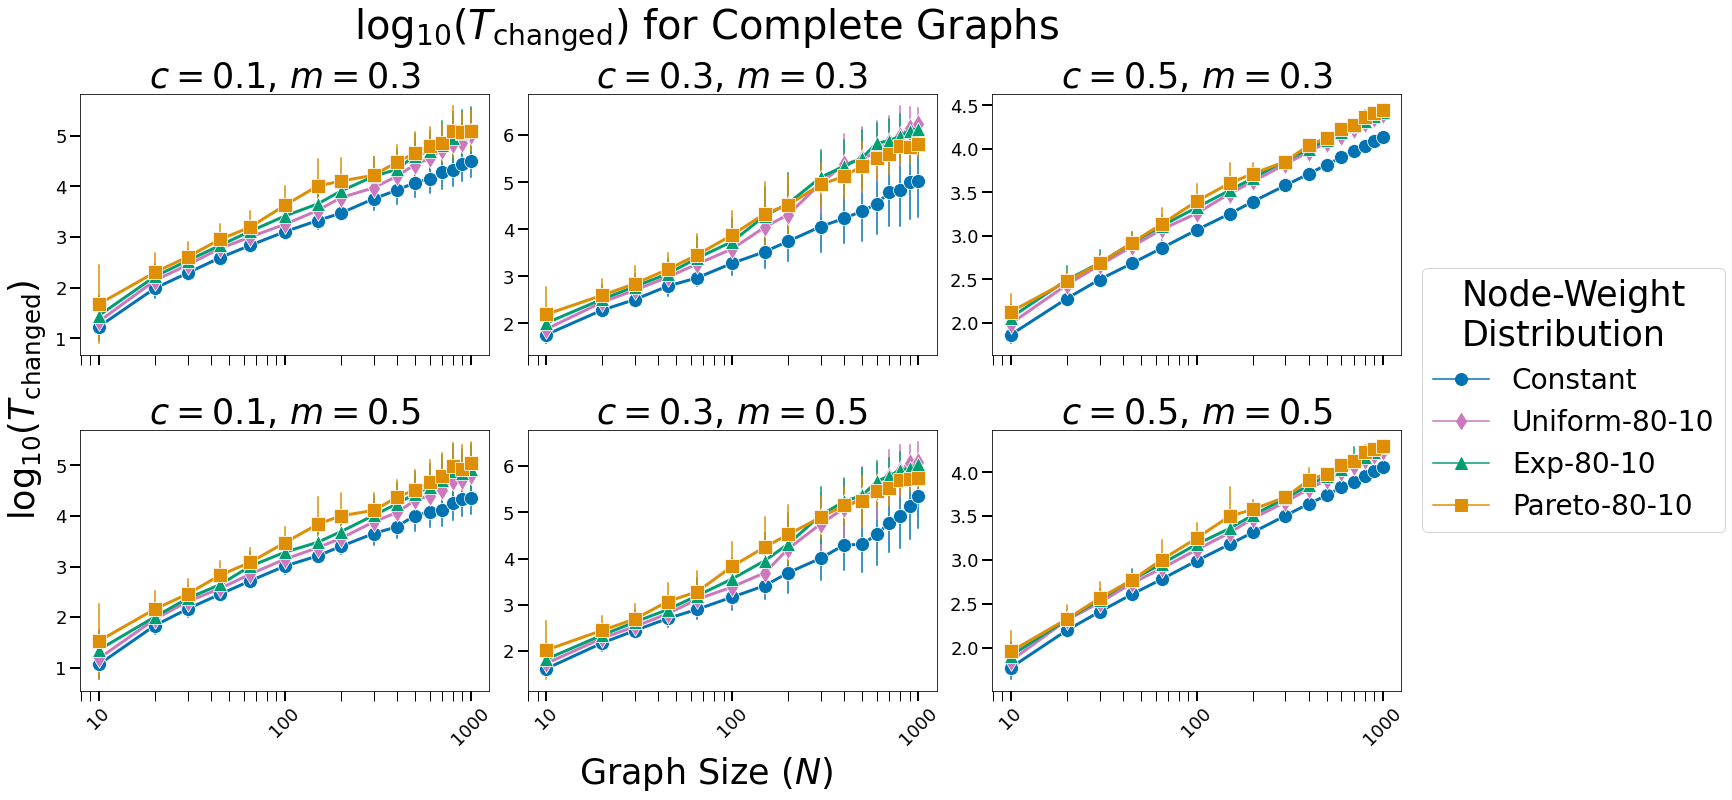

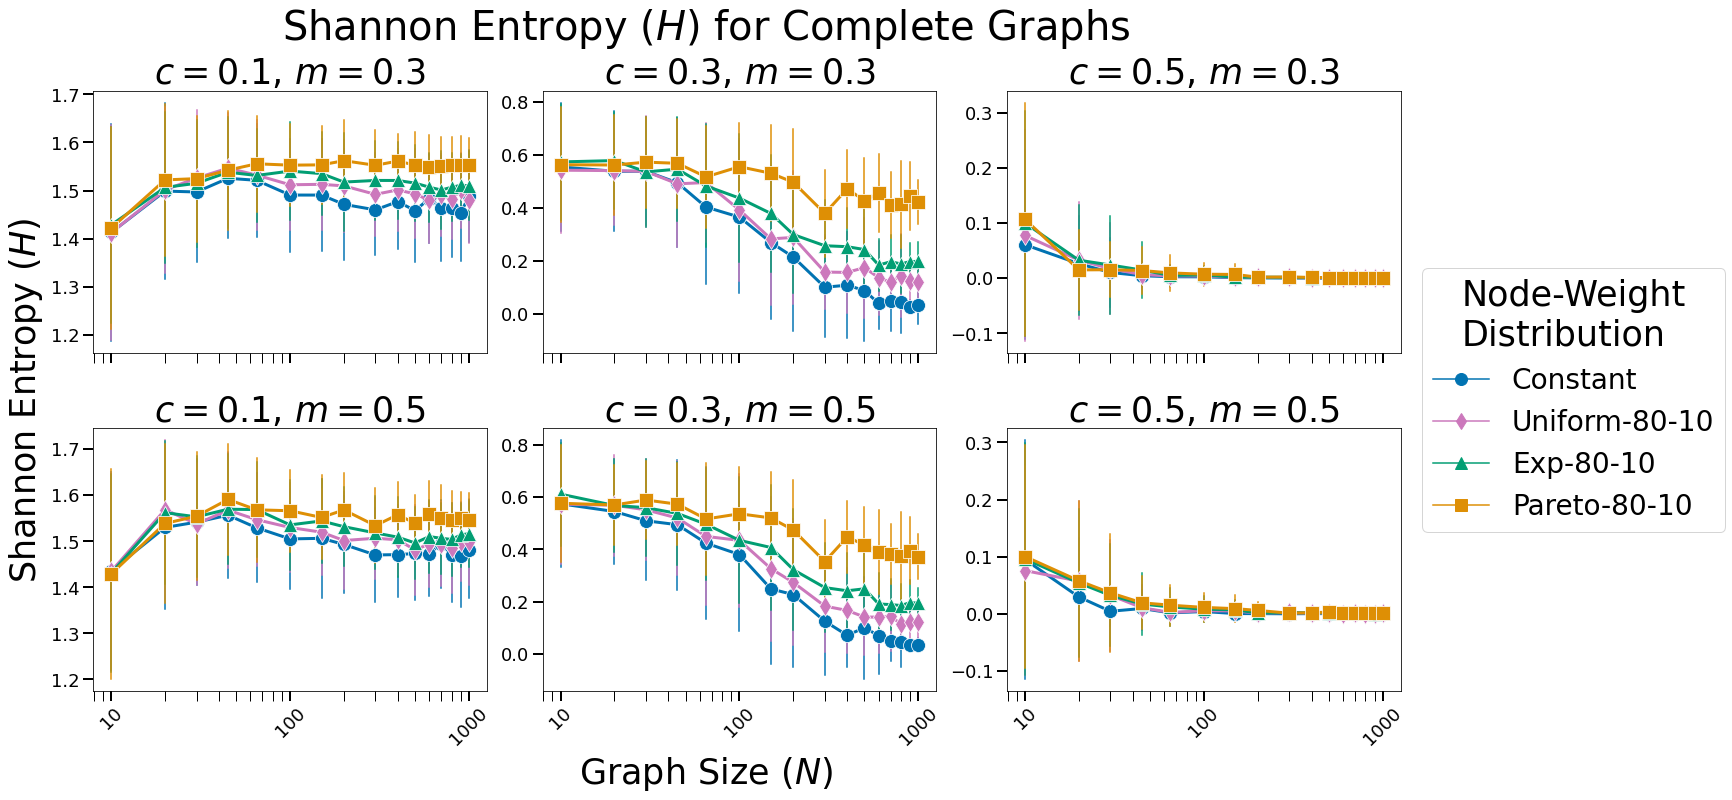

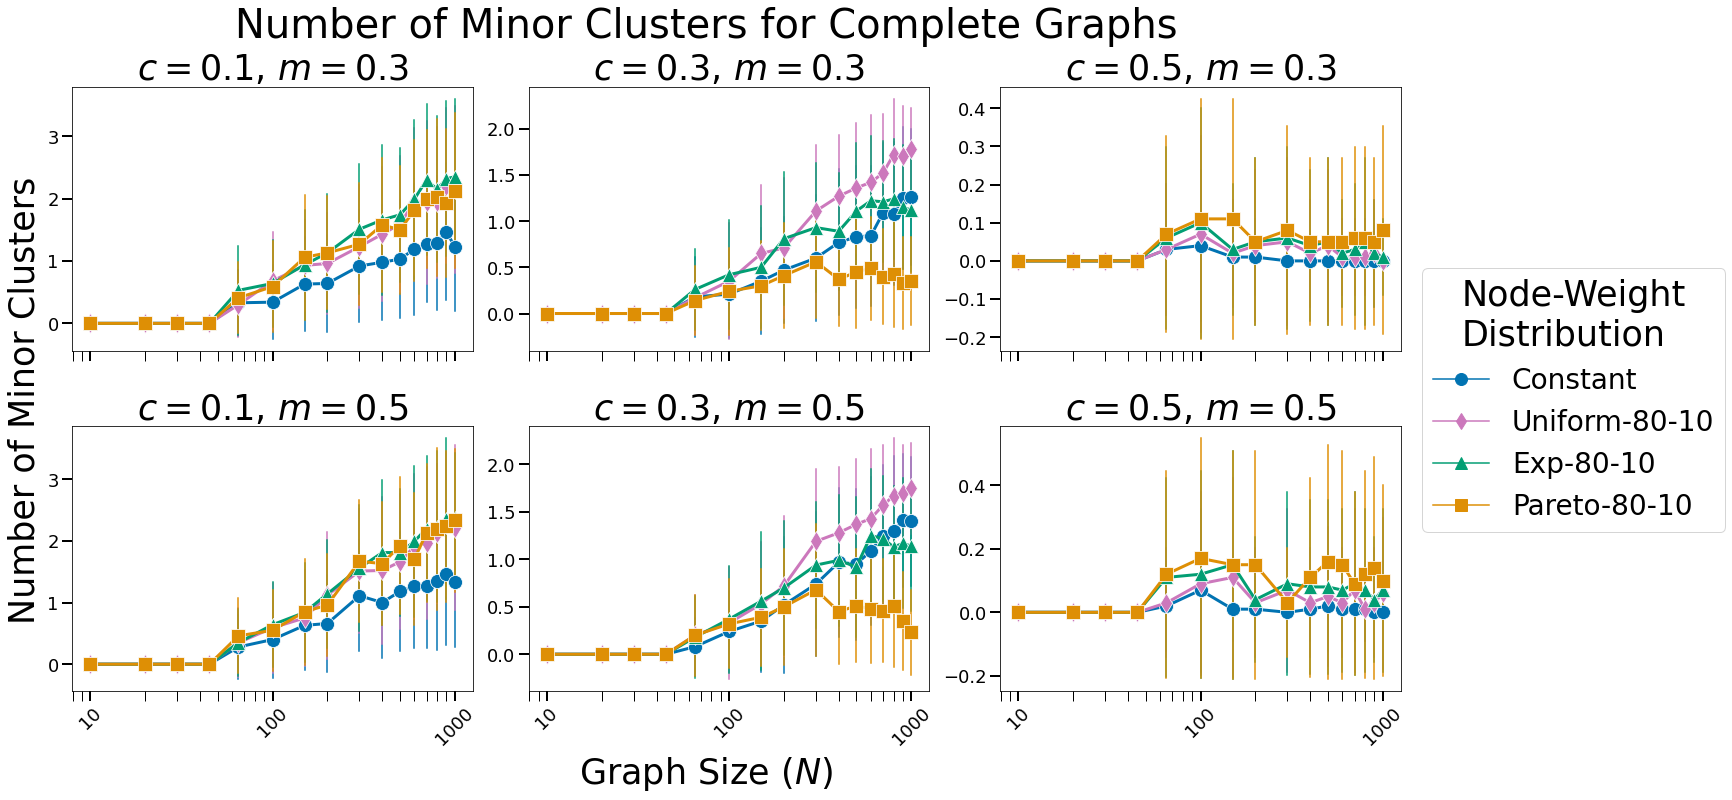

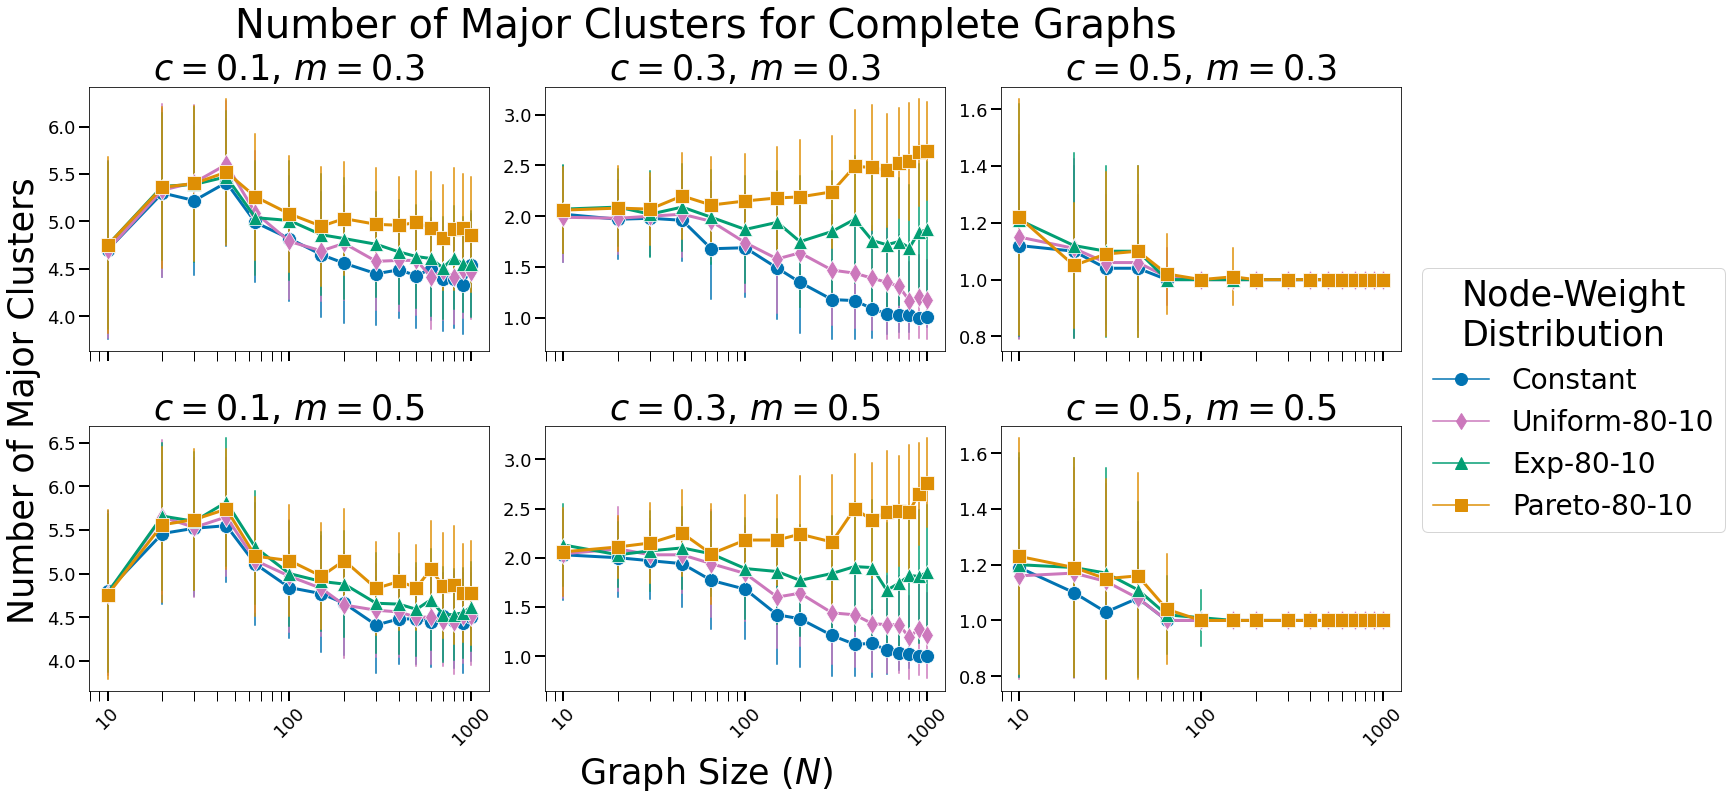

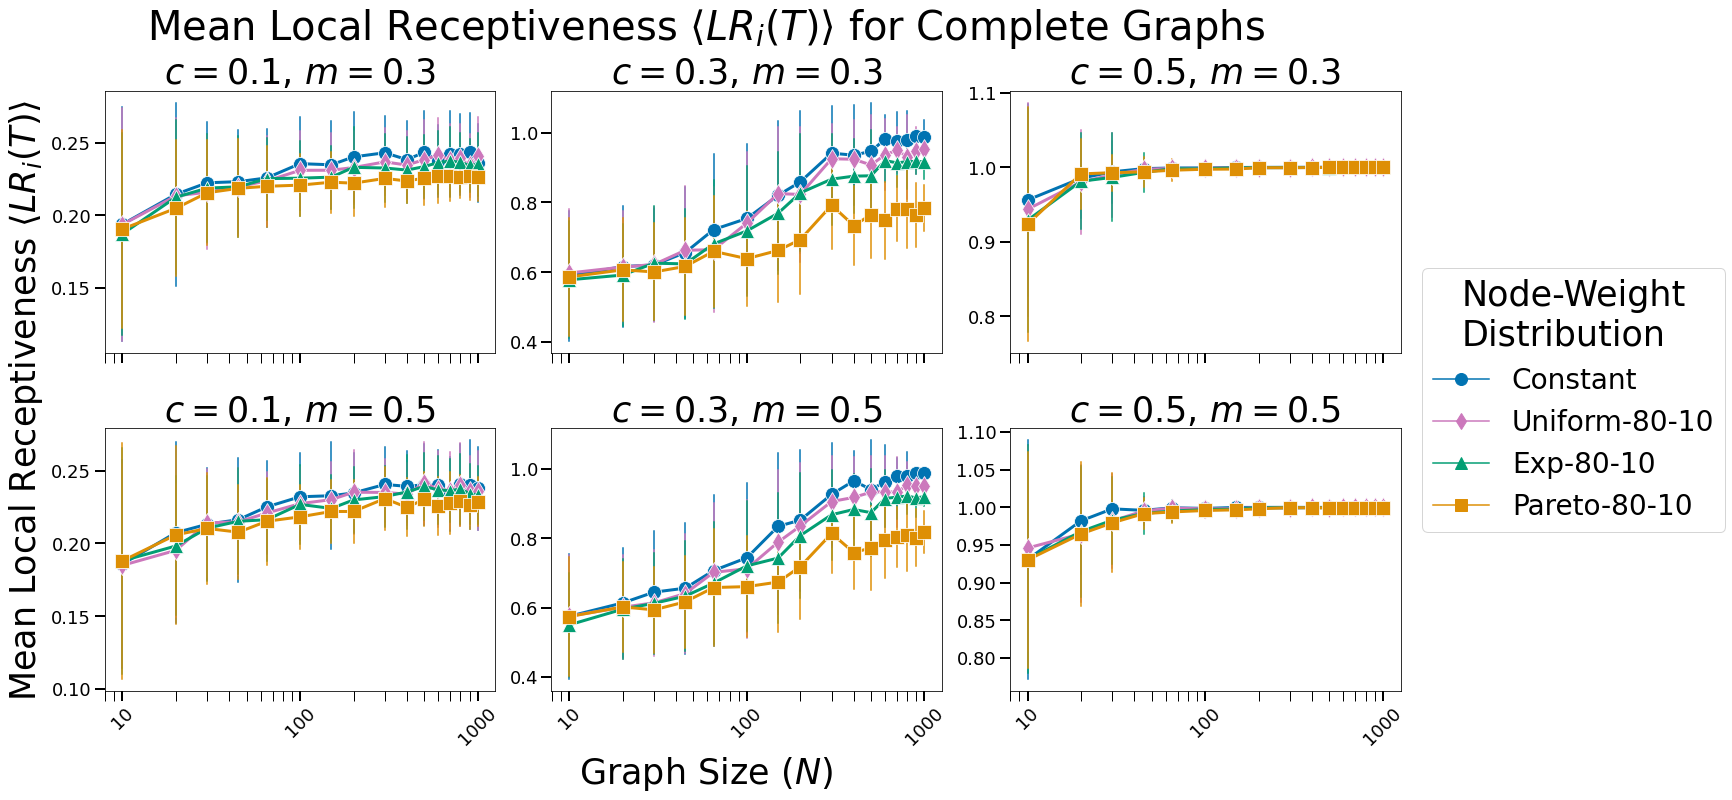

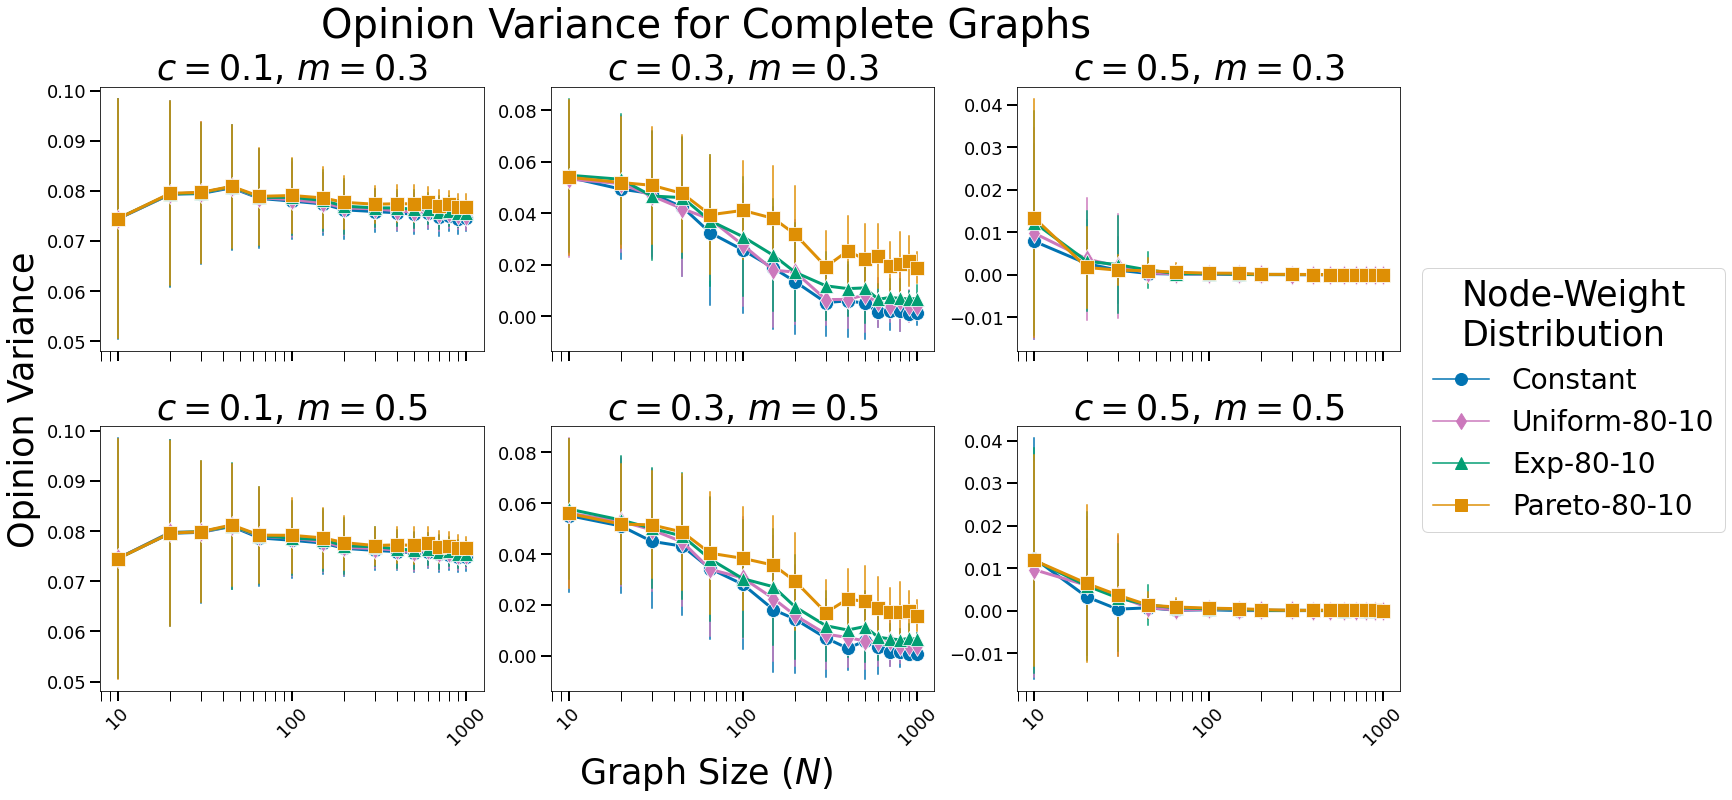

In [8]:
#Loop through the quantities of interest
for key in keys:

    fig, axs = plt.subplots(rows, cols, constrained_layout=True, figsize=figsize)
                            # sharex=True) #, sharey=True)
    
    #Generate each subplot
    for row in range(rows):
        for col in range(cols):
            
            #Get the d and mu values and the axis for this plot
            ax = axs[row, col]
            d = ds[col]
            mu = mus[row]
            
            #Initialize the dataframe to get all the results for this d, mu combo
            sim_results = pd.DataFrame()

            #For each graph size n and weight distribution, get the simulation results
            for n in Ns:

                for distribution in distributions:
                    #Get the combined dataframe of simulation outputs for this graph size n
                    df = get_sim_results(n, distribution)

                    #filter the data table by the d and mu values
                    df = df[df['d'] == d]
                    df = df[df['mu'] == mu]

                    sim_results = pd.concat([sim_results, df], ignore_index=True)
                    del df

            sim_results = sim_results.astype({'N': int}) #make sure the graph size is showing up as an integer
            sim_results["log10_N"] = np.log10(sim_results['N'])
            
            #Generate pointplot for visualization for this d, mu combo
            sns.lineplot(x="N", y=key, ax = ax, data=sim_results, hue='distribution', style = 'distribution',
                          errorbar="sd", err_style="bars", linewidth = 3,
                          palette = ['#0173b2', '#cc78bc', '#029e73', '#de8f05'],
                          markers = ['o', 'd', '^', 's'], dashes=False, markersize=14)
            # sns.pointplot(x="N", y=key, ax = ax, data=sim_results, hue='distribution',
            #               ci = 'sd', dodge=True, 
            #               palette = ['#0173b2', '#cc78bc', '#029e73', '#de8f05'],
            #               markers = ['o', 'd', '^', 's'], scale = 1.2)
            #               #palette = ['#009E73', '#F0E442', '#0072B2', '#D55E00']
            
            title = r"$c = $" + str(d) + r", $m = $" + str(mu)
            ax.set_title(title, fontsize = fontsizes['L'])
            
            ax.set(ylabel=None)
            ax.set(xlabel=None)
            
            ax.set_xscale('log')
            ax.tick_params('both', length=10, width=1, which='minor')
            ax.tick_params('both', length=10, width=2, which='major')
            if row != rows - 1:
                plt.setp(ax.get_xticklabels(), color="white")
            else:
                ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
                # ax.xaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
                ax.tick_params(axis="x", which="both", rotation=45)
            
#             #Label just the axes in just the first column and last row
#             if col == 0:
#                 ax.set_ylabel(plot_title[key], fontsize = fontsizes['M'])
#             else:
#                 ax.set(ylabel=None)
                
#             if row == rows - 1:
#                 ax.set_xlabel('Graph Size N', fontsize = fontsizes['M'])
#             else:
#                 ax.set(xlabel=None)
            
            ax.tick_params(axis='both', labelsize = fontsizes['S'])
            # ax.tick_params(axis = 'x', rotation = 45)
            
            #Hide the legend
            ax.get_legend().remove()

            #For the first gamma plot we generate, create a global legend in the last corner
            if row == 0 and col == 0:
                fig.legend(title = "Node-Weight\n" + "Distribution", loc='center left', bbox_to_anchor=bbox_to_anchor,
                          fontsize = fontsizes['M'], title_fontsize = fontsizes['L'], markerscale=2)
                # ax.legend(markerscale=6)
                
    suptitle = plot_title[key] + ' for Complete Graphs'
    fig.suptitle(suptitle, fontsize = fontsizes['XL'])
    
    fig.supxlabel(r"Graph Size ($N$)", fontsize = fontsizes['L'])
    fig.supylabel(plot_title[key], fontsize = fontsizes['L'])

    #Save the plot
    savefile = directory + f'/graph_size--{plot_name[key]}.png'
    plt.savefig(savefile, bbox_inches='tight', facecolor='white')
    plt.show()